## Evolutionary Algorithms for CNN Hyperparameter Optimization (NON Surrogate Assisted )

This notebook is used for running the EA and generating an evolved population. Visualizations are done in the `results.ipynb` notebook.

### Imports

In [1]:
from util import AlexNet, SmallCNN, get_loaders, train_model
from es import *
from surrogates import Surrogates
from copy import deepcopy

import oapackage
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import pickle
import os
import torch

### Evolutionary Algorithm: Initial Population and Statistics

In [2]:
# parameters come from es.py
mu=MU
lambda_=LAMBDA
sigma_crossover_rate=SIGMA_CROSSOVER_RATE
x_crossover_rate=X_CROSSOVER_RATE
sigma_mutation_rate=SIGMA_MUTATION_RATE
x_mutation_rate=X_MUTATION_RATE
max_generations=MAX_GENERATIONS
converge_threshold=CONVERGE_THRESHOLD
display_stats=True
train_concurrent=TRAIN_CONCURRENT

# Initialize population creation
population = [Genome() for _ in range(mu)]

# Update fitnesses using multiprocessing on full CNN  
with ProcessPoolExecutor(train_concurrent) as executor:
    results = list(tqdm(executor.map(fitness, population), total=len(population)))

# update fitnesses with results
for i in range(len(population)):
    population[i].valid_acc = results[i][0]
    population[i].loss_target_fitness = results[i][1]

# find the pareto front
pareto=oapackage.ParetoDoubleLong()
for ii in range(0, len(population)):
    w=oapackage.doubleVector((population[ii].valid_acc, population[ii].loss_target_fitness))
    pareto.addvalue(w, ii)

pareto_front = [population[ii] for ii in pareto.allindices()]

# Initialize lists to store generational statistics
generational_valid_acc_max = []
generational_valid_acc_min = []
generational_valid_acc_mean = []

generational_loss_target_max = []
generational_loss_target_min = []
generational_loss_target_mean = []

generational_pareto_fronts = []
generational_diversity = []

# get statistics about initial generation
vaild_accs = [genome.valid_acc for genome in population]
loss_targets = [genome.loss_target_fitness for genome in population]

generational_valid_acc_max.append(max(vaild_accs))
generational_valid_acc_min.append(min(vaild_accs))
generational_valid_acc_mean.append(np.mean(vaild_accs))

generational_loss_target_max.append(max(loss_targets))
generational_loss_target_min.append(min(loss_targets))
generational_loss_target_mean.append(np.mean(loss_targets))

generational_pareto_fronts.append(pareto_front)
generational_diversity.append(get_population_diversity(population))

fully_trained_population = []

# save fully trained population
fully_trained_population.append(deepcopy(population))
with open('fully_trained_population_control.pkl', 'wb') as f:
    pickle.dump(fully_trained_population, f) 

# Pickle generational statistics and save to file
with open(f'generational_stats_control.pkl', 'wb') as f: 
    pickle.dump((generational_valid_acc_max, generational_valid_acc_min, generational_valid_acc_mean,
                generational_loss_target_max, generational_loss_target_min, generational_loss_target_mean,
                generational_pareto_fronts,  generational_diversity), f)


100%|██████████| 10/10 [07:32<00:00, 45.29s/it]


### Evolutionary Algorithm: Main Loop

In [3]:
for gen_count in range(max_generations):
    # print generational stats
    if display_stats:
        print(f'{gen_count} {generational_valid_acc_min[-1]:.4f} {generational_valid_acc_mean[-1]:.4f} {generational_valid_acc_max[-1]:.4f}',
                f'{generational_loss_target_min[-1]:.4f} {generational_loss_target_mean[-1]:.4f} {generational_loss_target_max[-1]:.4f} {generational_diversity[-1]:.4f}')
        
    # container to store new generation
    new_population = []

    # loop to create new generation of size lambda_
    for i in range(lambda_ // 2):
        # Uniform random parent selection
        parent_1_idx = np.random.randint(0, len(population))
        parent_2_idx = np.random.randint(0, len(population))

        parent_1 = deepcopy(population[parent_1_idx])
        parent_2 = deepcopy(population[parent_2_idx])

        # sigma crossover (intermediate recombination)
        sigma_crossover(parent_1, parent_2, crossover_rate=sigma_crossover_rate)

        # sigma mutation 
        sigma_mutate(parent_1, mutation_rate=sigma_mutation_rate)
        sigma_mutate(parent_2, mutation_rate=sigma_mutation_rate)
        
        # x crossover intermediate recombination
        crossover(parent_1, parent_2, crossover_rate=x_crossover_rate)

        # x mutation
        mutate(parent_1, mutation_rate=x_mutation_rate)
        mutate(parent_2, mutation_rate=x_mutation_rate)
            
        # add to new generation
        new_population.append(parent_1)
        new_population.append(parent_2)

    # limit genome X values to be within bounds
    for genome in new_population:
        genome.x[0] = np.clip(genome.x[0], 0, 0.2)
        genome.x[1] = np.clip(genome.x[1], 0, 0.999)
        genome.x[2] = np.clip(genome.x[2], 0, 0.05)

    # Update fitnesses using multiprocessing on full CNN  
    with ProcessPoolExecutor(train_concurrent) as executor:
        results = list(tqdm(executor.map(fitness, new_population), total=len(new_population)))
    
    # update fitnesses with results
    for i in range(len(new_population)):
        new_population[i].valid_acc = results[i][0]
        new_population[i].loss_target_fitness = results[i][1]
   
    # add new generation to population
    population.extend(new_population)

    # find the pareto front
    pareto=oapackage.ParetoDoubleLong()
    for ii in range(0, len(population)):
        w=oapackage.doubleVector((population[ii].valid_acc, population[ii].loss_target_fitness))
        pareto.addvalue(w, ii)

    pareto_front = [population[ii] for ii in pareto.allindices()]

    # chose the top mu/2 from the pareto front based on crowding distance
    X = np.array([genome.x for genome in pareto_front])
    distances = CrowdingDist(X)
    new_front = []
    sorted_indexes = np.argsort(distances)[::-1]
    for idx in sorted_indexes[:int(mu / 2)]:
        new_front.append(pareto_front[idx])
    pareto_front = new_front

    # create a new population consisting of the pareto front, the top validation accuracy, and the top loss target fitness
    new_population = [genome for genome in pareto_front]

    sorted1 = sorted(population, key=lambda genome: genome.valid_acc, reverse=True)
    sorted2 = sorted(population, key=lambda genome: genome.loss_target_fitness, reverse=True)
    while len(new_population) < mu-1:
        new_population.append(sorted1.pop(0))
        new_population.append(sorted2.pop(0))
        new_population = list(set(new_population))

    population = new_population

    # get statistics about new population
    vaild_accs = [genome.valid_acc for genome in population]
    loss_targets = [genome.loss_target_fitness for genome in population]

    generational_valid_acc_max.append(max(vaild_accs))
    generational_valid_acc_min.append(min(vaild_accs))
    generational_valid_acc_mean.append(np.mean(vaild_accs))

    generational_loss_target_max.append(max(loss_targets))
    generational_loss_target_min.append(min(loss_targets))
    generational_loss_target_mean.append(np.mean(loss_targets))

    generational_pareto_fronts.append(pareto_front)
    generational_diversity.append(get_population_diversity(population))

    # save fully trained population
    fully_trained_population.append(deepcopy(population))
    with open('fully_trained_population_control.pkl', 'wb') as f:
        pickle.dump(fully_trained_population, f) 

    # Pickle generational statistics and save to file
    with open(f'generational_stats_control.pkl', 'wb') as f: 
        pickle.dump((generational_valid_acc_max, generational_valid_acc_min, generational_valid_acc_mean,
                    generational_loss_target_max, generational_loss_target_min, generational_loss_target_mean,
                    generational_pareto_fronts,  generational_diversity), f)

    # Check for termination conditions
    # (1) - terminate if generational diversity is below threshold
    # if generational_diversity[-1] < converge_threshold :
    #     if display_stats:
    #         print(f'Population has converged with generational diversity below threshold of {converge_threshold }')
    #     break

    # (2) - terminate after max_generations (display message)
    if gen_count == max_generations - 1 and display_stats:
        print('The maximum number of generations has been reached')




0 12.7000 35.2470 66.1800 12.6760 37.1622 72.2460 0.9383


100%|██████████| 20/20 [14:55<00:00, 44.78s/it]  


1 37.5300 51.2350 69.3100 37.4520 55.1344 80.4900 0.6491


100%|██████████| 20/20 [14:55<00:00, 44.78s/it]  


2 58.7500 64.3611 70.0000 66.3840 73.2502 81.6740 0.3405


100%|██████████| 20/20 [14:55<00:00, 44.80s/it]  


3 65.5300 68.1033 70.0000 72.2460 78.6733 81.6740 0.3405


100%|██████████| 20/20 [15:02<00:00, 45.14s/it]  


4 67.5600 68.8422 70.0000 78.1300 80.3062 82.3040 0.4822


100%|██████████| 20/20 [15:01<00:00, 45.08s/it]  


5 68.1500 69.4590 70.5600 79.7280 81.2326 82.9940 0.4822


100%|██████████| 20/20 [15:00<00:00, 45.00s/it]  


6 68.9800 70.4567 72.8400 79.7280 82.6551 86.3700 0.7699


100%|██████████| 20/20 [15:13<00:00, 45.66s/it]  


7 69.4400 71.2156 73.5800 80.4300 83.9609 87.0080 0.7341


100%|██████████| 20/20 [15:09<00:00, 45.50s/it]  


8 69.4400 71.2670 73.5800 80.4300 84.0964 87.0080 0.7341


100%|██████████| 20/20 [15:10<00:00, 45.51s/it]  


9 70.0200 71.6411 73.5800 82.3880 84.7062 87.0080 0.7341


100%|██████████| 20/20 [15:03<00:00, 45.16s/it]  


The maximum number of generations has been reached


In [4]:
len(pareto_front)

1

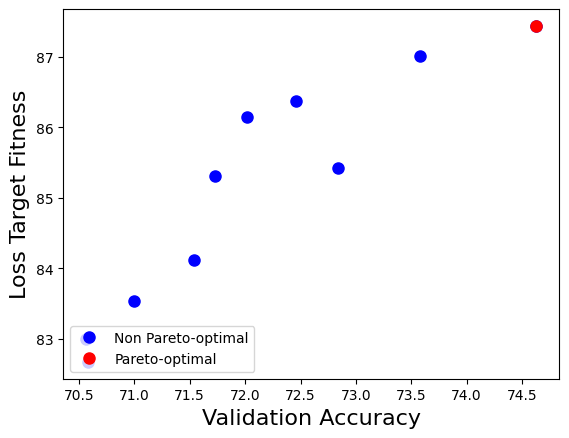

In [5]:

# for pareto_front in generational_pareto_fronts:
#     plt.figure(figsize=(8,8))
#     plt.plot([genome.valid_acc for genome in pareto_front], [genome.loss_target_fitness for genome in pareto_front], '.r', markersize=16, label='Pareto-optimal')
#     plt.xlabel('Validation Accuracy', fontsize=16)
#     plt.ylabel('Loss Target Fitness', fontsize=16)
#     _=plt.legend(loc=3, numpoints=1)
pareto_front = generational_pareto_fronts[-1]
plt.plot([genome.valid_acc for genome in population], [genome.loss_target_fitness for genome in population], '.b', markersize=16, label='Non Pareto-optimal')
plt.plot([genome.valid_acc for genome in pareto_front], [genome.loss_target_fitness for genome in pareto_front], '.r', markersize=16, label='Pareto-optimal')
plt.xlabel('Validation Accuracy', fontsize=16)
plt.ylabel('Loss Target Fitness', fontsize=16)
_=plt.legend(loc=3, numpoints=1)

Text(0, 0.5, 'Diversity')

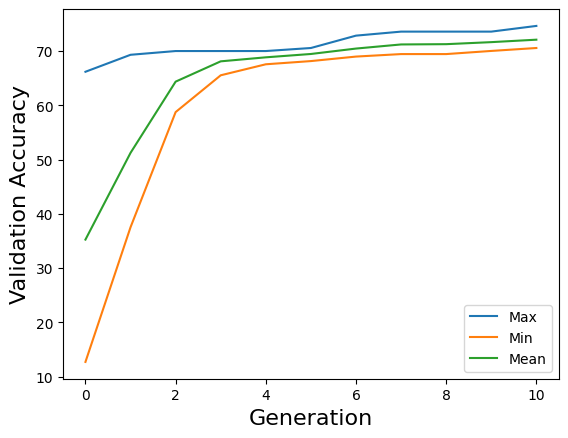

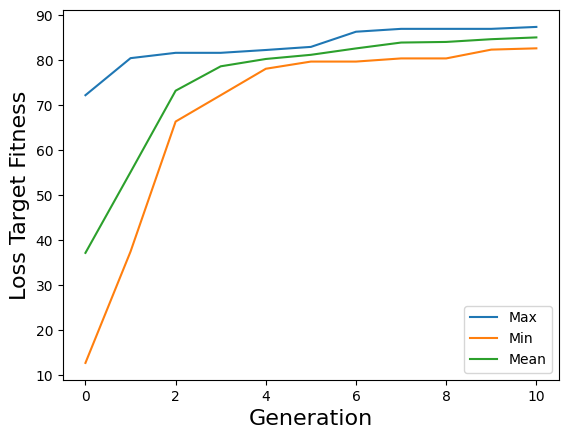

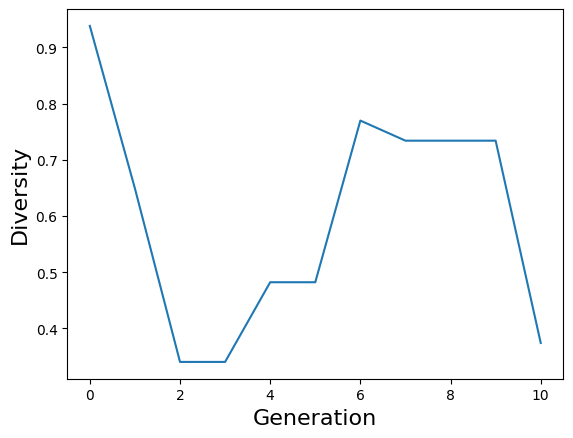

In [6]:
# graph generational statistics
plt.figure()
plt.plot(generational_valid_acc_max, label='Max')
plt.plot(generational_valid_acc_min, label='Min')
plt.plot(generational_valid_acc_mean, label='Mean')
plt.xlabel('Generation', fontsize=16)
plt.ylabel('Validation Accuracy', fontsize=16)
plt.legend(loc=4, numpoints=1)

plt.figure()
plt.plot(generational_loss_target_max, label='Max')
plt.plot(generational_loss_target_min, label='Min')
plt.plot(generational_loss_target_mean, label='Mean')
plt.xlabel('Generation', fontsize=16)
plt.ylabel('Loss Target Fitness', fontsize=16)
plt.legend(loc=4, numpoints=1)


# graph generational diversity
plt.figure()
plt.plot(generational_diversity)
plt.xlabel('Generation', fontsize=16)
plt.ylabel('Diversity', fontsize=16)

